In [1]:
import pandas as pd

In [2]:
df = pd.read_csv('../data/03_casos/df_53_cleaned.csv')

In [3]:
df.size

72384

In [4]:
df.head()

,ano,semana,ira_no_neumonia,neumonias_men5,neumonias_60mas,hospitalizados_men5,hospitalizados_60mas,defunciones_men5,defunciones_60mas,sub_reg_nt,...,defunciones_60mas_lag_3_semana,defunciones_60mas_lag_4_semana,defunciones_60mas_lag_5_semana,defunciones_60mas_lag_6_semana,mes,bimestre,trimestre,cuatrimestre,semestre,pandemia_covid
0,2000,1,2660,14,0,0,0,0,0,53,...,0.0,0.0,0.0,0.0,1,1,1,1,1,0
1,2000,2,2567,8,0,0,0,0,0,53,...,0.0,0.0,0.0,0.0,1,1,1,1,1,0
2,2000,3,2230,15,0,0,0,0,0,53,...,0.0,0.0,0.0,0.0,1,1,1,1,1,0
3,2000,4,2067,12,0,0,0,0,0,53,...,0.0,0.0,0.0,0.0,1,1,1,1,1,0
4,2000,5,1677,8,0,0,0,0,0,53,...,0.0,0.0,0.0,0.0,2,1,1,1,1,0


In [5]:
df.columns

Index(['ano', 'semana', 'ira_no_neumonia', 'neumonias_men5', 'neumonias_60mas',
       'hospitalizados_men5', 'hospitalizados_60mas', 'defunciones_men5',
       'defunciones_60mas', 'sub_reg_nt', 'ira_no_neumonia_lag_1_semana',
       'ira_no_neumonia_lag_2_semana', 'ira_no_neumonia_lag_3_semana',
       'ira_no_neumonia_lag_4_semana', 'ira_no_neumonia_lag_5_semana',
       'ira_no_neumonia_lag_6_semana', 'neumonias_men5_lag_1_semana',
       'neumonias_men5_lag_2_semana', 'neumonias_men5_lag_3_semana',
       'neumonias_men5_lag_4_semana', 'neumonias_men5_lag_5_semana',
       'neumonias_men5_lag_6_semana', 'neumonias_60mas_lag_1_semana',
       'neumonias_60mas_lag_2_semana', 'neumonias_60mas_lag_3_semana',
       'neumonias_60mas_lag_4_semana', 'neumonias_60mas_lag_5_semana',
       'neumonias_60mas_lag_6_semana', 'hospitalizados_men5_lag_1_semana',
       'hospitalizados_men5_lag_2_semana', 'hospitalizados_men5_lag_3_semana',
       'hospitalizados_men5_lag_4_semana', 'hospitalizad

Vamos a entrenar un mismo modelo de forecasting para la predicción de `hospitalizados_men5`, considerando los siguientes escenarios:

### Por años [2000 a 2023]

- Entrenar usando:  
  **Variables:** `ano`, `semana`  
  **Target:** `hospitalizados_men5`

- Entrenar usando:  
  **Variables:** `ano`, `semana`, `pandemia_covid`  
  **Target:** `hospitalizados_men5`

- Entrenar usando:  
  **Variables:** `ano`, `semana`, `ira_no_neumonia`, `neumonias_men5`, `neumonias_60mas`, `hospitalizados_60mas`, `defunciones_men5`, `defunciones_60mas`  
  **Target:** `hospitalizados_men5`

- Entrenar usando:  
  **Variables:** `ano`, `semana`, `ira_no_neumonia`, `neumonias_men5`, `neumonias_60mas`, `hospitalizados_60mas`, `defunciones_men5`, `defunciones_60mas`, y sus variables *lag* (`_lag_1_semana` a `_lag_6_semana`)  
  **Target:** `hospitalizados_men5`

- Entrenar usando:  
  **Variables:** `ano`, `semana`, `hospitalizados_60mas_lag_1_semana`, `defunciones_men5_lag_1_semana`, `defunciones_60mas_lag_1_semana`, `defunciones_men5_lag_3_semana`   
  **Target:** `hospitalizados_men5`


### Por años [2022 a 2023]

- Entrenar usando:  
  **Variables:** `ano`, `semana`  
  **Target:** `hospitalizados_men5`

- Entrenar usando:  
  **Variables:** `ano`, `semana`, `ira_no_neumonia`, `neumonias_men5`, `neumonias_60mas`, `hospitalizados_60mas`, `defunciones_men5`, `defunciones_60mas`  
  **Target:** `hospitalizados_men5`

- Entrenar usando:  
  **Variables:** `ano`, `semana`, `ira_no_neumonia`, `neumonias_men5`, `neumonias_60mas`, `hospitalizados_60mas`, `defunciones_men5`, `defunciones_60mas`, y sus variables *lag* (`_lag_1_semana` a `_lag_6_semana`)  
  **Target:** `hospitalizados_men5`

- Entrenar usando:  
  **Variables:** `ano`, `semana`, `hospitalizados_60mas_lag_1_semana`, `defunciones_men5_lag_1_semana`, `defunciones_60mas_lag_1_semana`, `defunciones_men5_lag_3_semana`   
  **Target:** `hospitalizados_men5`

## Modelos de Series Temporales: ARMA, ARIMA y SARIMA

Los modelos de series temporales requieren preparación especial de los datos. Trabajaremos con la serie temporal de `hospitalizados_men5` para diferentes períodos.

In [6]:
# Importar librerías necesarias para modelos de series temporales
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller, acf, pacf
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [7]:
# Diccionario para almacenar resultados de todos los modelos
resultados_modelos = {}

### Escenario 1: Años 2000-2023 - Serie temporal completa

In [8]:
# Preparar datos para serie temporal 2000-2023
df_2000_2023 = df.copy()
df_2000_2023 = df_2000_2023.sort_values(['ano', 'semana']).reset_index(drop=True)

# Variable objetivo
serie_temporal = df_2000_2023['hospitalizados_men5']

# División train/test (80/20)
split_point = int(len(serie_temporal) * 0.8)
train_series = serie_temporal[:split_point]
test_series = serie_temporal[split_point:]

print(f"Total observaciones: {len(serie_temporal)}")
print(f"Train: {len(train_series)} observaciones")
print(f"Test: {len(test_series)} observaciones")

Total observaciones: 1248
Train: 998 observaciones
Test: 250 observaciones


#### Modelo ARMA (AutoRegressive Moving Average)

ARMA combina componentes autorregresivos (AR) y de media móvil (MA). Es apropiado para series estacionarias.

In [9]:
# Modelo ARMA(p,q) - Usando ARIMA con d=0
# p: orden autorregresivo, q: orden de media móvil
# Valores comunes: ARMA(1,1), ARMA(2,1), ARMA(1,2)

# ARMA(2,2) - ajustar según análisis ACF/PACF
arma_model = ARIMA(train_series, order=(2, 0, 2))
arma_fit = arma_model.fit()

# Predicciones
arma_predictions = arma_fit.forecast(steps=len(test_series))

# Métricas
arma_mae = mean_absolute_error(test_series, arma_predictions)
arma_rmse = np.sqrt(mean_squared_error(test_series, arma_predictions))
arma_r2 = r2_score(test_series, arma_predictions)

# Guardar resultados
resultados_modelos['ARMA_2000-2023'] = {
    'modelo': 'ARMA(2,0,2)',
    'periodo': '2000-2023',
    'MAE': arma_mae,
    'RMSE': arma_rmse,
    'R2': arma_r2
}

print("Modelo ARMA(2,0,2) - 2000-2023")
print(f"MAE: {arma_mae:.4f}")
print(f"RMSE: {arma_rmse:.4f}")
print(f"R²: {arma_r2:.4f}")
print("\nResumen del modelo:")
print(arma_fit.summary())

Modelo ARMA(2,0,2) - 2000-2023
MAE: 3.9621
RMSE: 4.5163
R²: -0.3841

Resumen del modelo:
                                SARIMAX Results                                
Dep. Variable:     hospitalizados_men5   No. Observations:                  998
Model:                  ARIMA(2, 0, 2)   Log Likelihood               -2768.146
Date:                 Sat, 18 Oct 2025   AIC                           5548.292
Time:                         15:16:50   BIC                           5577.726
Sample:                              0   HQIC                          5559.480
                                 - 998                                         
Covariance Type:                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.7707      1.058      5.452      0.000       3.696       7.845
ar.L1          1.6629      0.135  

#### Modelo ARIMA (AutoRegressive Integrated Moving Average)

ARIMA incluye un componente de diferenciación (I) para manejar series no estacionarias.

In [10]:
# Modelo ARIMA(p,d,q)
# p: orden autorregresivo, d: orden de diferenciación, q: orden de media móvil
# Valores comunes: ARIMA(1,1,1), ARIMA(2,1,2), ARIMA(1,1,0)

# ARIMA(2,1,2) - ajustar según análisis de estacionariedad
arima_model = ARIMA(train_series, order=(2, 1, 2))
arima_fit = arima_model.fit()

# Predicciones
arima_predictions = arima_fit.forecast(steps=len(test_series))

# Métricas
arima_mae = mean_absolute_error(test_series, arima_predictions)
arima_rmse = np.sqrt(mean_squared_error(test_series, arima_predictions))
arima_r2 = r2_score(test_series, arima_predictions)

# Guardar resultados
resultados_modelos['ARIMA_2000-2023'] = {
    'modelo': 'ARIMA(2,1,2)',
    'periodo': '2000-2023',
    'MAE': arima_mae,
    'RMSE': arima_rmse,
    'R2': arima_r2
}

print("Modelo ARIMA(2,1,2) - 2000-2023")
print(f"MAE: {arima_mae:.4f}")
print(f"RMSE: {arima_rmse:.4f}")
print(f"R²: {arima_r2:.4f}")
print("\nResumen del modelo:")
print(arima_fit.summary())

Modelo ARIMA(2,1,2) - 2000-2023
MAE: 3.2326
RMSE: 3.9047
R²: -0.0346

Resumen del modelo:
                                SARIMAX Results                                
Dep. Variable:     hospitalizados_men5   No. Observations:                  998
Model:                  ARIMA(2, 1, 2)   Log Likelihood               -2766.934
Date:                 Sat, 18 Oct 2025   AIC                           5543.868
Time:                         15:16:51   BIC                           5568.392
Sample:                              0   HQIC                          5553.190
                                 - 998                                         
Covariance Type:                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0129      0.061     16.536      0.000       0.893       1.133
ar.L2         -0.0994      0.041 

#### Modelo SARIMA (Seasonal ARIMA)

SARIMA añade componentes estacionales para capturar patrones que se repiten en intervalos fijos (por ejemplo, semanalmente, mensualmente).

In [11]:
# Modelo SARIMA(p,d,q)(P,D,Q,s)
# (p,d,q): componentes no estacionales
# (P,D,Q,s): componentes estacionales, donde s es el periodo estacional
# Para datos semanales, s=52 (semanas por año)

# SARIMA(1,1,1)(1,1,1,52) - modelo con estacionalidad anual
sarima_model = SARIMAX(train_series, 
                       order=(1, 1, 1),
                       seasonal_order=(1, 1, 1, 52),
                       enforce_stationarity=False,
                       enforce_invertibility=False)
sarima_fit = sarima_model.fit(disp=False)

# Predicciones
sarima_predictions = sarima_fit.forecast(steps=len(test_series))

# Métricas
sarima_mae = mean_absolute_error(test_series, sarima_predictions)
sarima_rmse = np.sqrt(mean_squared_error(test_series, sarima_predictions))
sarima_r2 = r2_score(test_series, sarima_predictions)

# Guardar resultados
resultados_modelos['SARIMA_2000-2023'] = {
    'modelo': 'SARIMA(1,1,1)(1,1,1,52)',
    'periodo': '2000-2023',
    'MAE': sarima_mae,
    'RMSE': sarima_rmse,
    'R2': sarima_r2
}

print("Modelo SARIMA(1,1,1)(1,1,1,52) - 2000-2023")
print(f"MAE: {sarima_mae:.4f}")
print(f"RMSE: {sarima_rmse:.4f}")
print(f"R²: {sarima_r2:.4f}")
print("\nResumen del modelo:")
print(sarima_fit.summary())

Modelo SARIMA(1,1,1)(1,1,1,52) - 2000-2023
MAE: 3.2061
RMSE: 4.0057
R²: -0.0888

Resumen del modelo:
                                     SARIMAX Results                                      
Dep. Variable:                hospitalizados_men5   No. Observations:                  998
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 52)   Log Likelihood               -2554.132
Date:                            Sat, 18 Oct 2025   AIC                           5118.264
Time:                                    15:18:26   BIC                           5142.226
Sample:                                         0   HQIC                          5127.422
                                            - 998                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1        

### Escenario 2: Años 2021-2023 - Periodo reciente

In [12]:
# Preparar datos para serie temporal 2022-2023
df_2022_2023 = df[df['ano'] >= 2022].copy()
df_2022_2023 = df_2022_2023.sort_values(['ano', 'semana']).reset_index(drop=True)

# Variable objetivo
serie_temporal_2022 = df_2022_2023['hospitalizados_men5']

# División train/test (80/20)
split_point_2022 = int(len(serie_temporal_2022) * 0.8)
train_series_2022 = serie_temporal_2022[:split_point_2022]
test_series_2022 = serie_temporal_2022[split_point_2022:]

print(f"Total observaciones 2022-2023: {len(serie_temporal_2022)}")
print(f"Train: {len(train_series_2022)} observaciones")
print(f"Test: {len(test_series_2022)} observaciones")

Total observaciones 2022-2023: 104
Train: 83 observaciones
Test: 21 observaciones


#### ARMA - Periodo 2021-2023

In [13]:
# Modelo ARMA para 2022-2023
arma_model_2022 = ARIMA(train_series_2022, order=(2, 0, 2))
arma_fit_2022 = arma_model_2022.fit()

# Predicciones
arma_predictions_2022 = arma_fit_2022.forecast(steps=len(test_series_2022))

# Métricas
arma_mae_2022 = mean_absolute_error(test_series_2022, arma_predictions_2022)
arma_rmse_2022 = np.sqrt(mean_squared_error(test_series_2022, arma_predictions_2022))
arma_r2_2022 = r2_score(test_series_2022, arma_predictions_2022)

# Guardar resultados
resultados_modelos['ARMA_2022-2023'] = {
    'modelo': 'ARMA(2,0,2)',
    'periodo': '2022-2023',
    'MAE': arma_mae_2022,
    'RMSE': arma_rmse_2022,
    'R2': arma_r2_2022
}

print("Modelo ARMA(2,0,2) - 2022-2023")
print(f"MAE: {arma_mae_2022:.4f}")
print(f"RMSE: {arma_rmse_2022:.4f}")
print(f"R²: {arma_r2_2022:.4f}")

Modelo ARMA(2,0,2) - 2022-2023
MAE: 1.9906
RMSE: 2.5673
R²: -0.6257


#### ARIMA - Periodo 2021-2023

In [14]:
# Modelo ARIMA para 2022-2023
arima_model_2022 = ARIMA(train_series_2022, order=(2, 1, 2))
arima_fit_2022 = arima_model_2022.fit()

# Predicciones
arima_predictions_2022 = arima_fit_2022.forecast(steps=len(test_series_2022))

# Métricas
arima_mae_2022 = mean_absolute_error(test_series_2022, arima_predictions_2022)
arima_rmse_2022 = np.sqrt(mean_squared_error(test_series_2022, arima_predictions_2022))
arima_r2_2022 = r2_score(test_series_2022, arima_predictions_2022)

# Guardar resultados
resultados_modelos['ARIMA_2022-2023'] = {
    'modelo': 'ARIMA(2,1,2)',
    'periodo': '2022-2023',
    'MAE': arima_mae_2022,
    'RMSE': arima_rmse_2022,
    'R2': arima_r2_2022
}

print("Modelo ARIMA(2,1,2) - 2022-2023")
print(f"MAE: {arima_mae_2022:.4f}")
print(f"RMSE: {arima_rmse_2022:.4f}")
print(f"R²: {arima_r2_2022:.4f}")

Modelo ARIMA(2,1,2) - 2022-2023
MAE: 2.8604
RMSE: 3.3992
R²: -1.8499


#### SARIMA - Periodo 2021-2023

In [15]:
# Modelo SARIMA para 2022-2023
sarima_model_2022 = SARIMAX(train_series_2022, 
                            order=(1, 1, 1),
                            seasonal_order=(1, 1, 1, 52),
                            enforce_stationarity=False,
                            enforce_invertibility=False)
sarima_fit_2022 = sarima_model_2022.fit(disp=False)

# Predicciones
sarima_predictions_2022 = sarima_fit_2022.forecast(steps=len(test_series_2022))

# Métricas
sarima_mae_2022 = mean_absolute_error(test_series_2022, sarima_predictions_2022)
sarima_rmse_2022 = np.sqrt(mean_squared_error(test_series_2022, sarima_predictions_2022))
sarima_r2_2022 = r2_score(test_series_2022, sarima_predictions_2022)

# Guardar resultados
resultados_modelos['SARIMA_2022-2023'] = {
    'modelo': 'SARIMA(1,1,1)(1,1,1,52)',
    'periodo': '2022-2023',
    'MAE': sarima_mae_2022,
    'RMSE': sarima_rmse_2022,
    'R2': sarima_r2_2022
}

print("Modelo SARIMA(1,1,1)(1,1,1,52) - 2022-2023")
print(f"MAE: {sarima_mae_2022:.4f}")
print(f"RMSE: {sarima_rmse_2022:.4f}")
print(f"R²: {sarima_r2_2022:.4f}")

Modelo SARIMA(1,1,1)(1,1,1,52) - 2022-2023
MAE: 2.5176
RMSE: 3.4547
R²: -1.9437


### Comparación de Desempeño de Modelos de Series Temporales

Tabla comparativa de todas las métricas de evaluación para los modelos ARMA, ARIMA y SARIMA.

In [16]:
# Crear DataFrame comparativo de resultados
df_comparacion = pd.DataFrame(resultados_modelos).T
df_comparacion = df_comparacion.round(4)

# Ordenar por R² (descendente) para ver mejor desempeño primero
df_comparacion_sorted = df_comparacion.sort_values('R2', ascending=False)

print("="*80)
print("COMPARACIÓN DE DESEMPEÑO - MODELOS DE SERIES TEMPORALES")
print("="*80)
print("\nTarget: hospitalizados_men5")
print("\nMétricas de Evaluación:")
print("  - MAE (Mean Absolute Error): Menor es mejor")
print("  - RMSE (Root Mean Squared Error): Menor es mejor")
print("  - R² (Coeficiente de Determinación): Mayor es mejor (cercano a 1)")
print("\n" + "="*80)
print("\nRESULTADOS ORDENADOS POR R² (MEJOR A PEOR):")
print("="*80)
print(df_comparacion_sorted.to_string())
print("\n" + "="*80)

# Identificar el mejor modelo para cada métrica
print("\nMEJOR MODELO POR MÉTRICA:")
print("="*80)
mejor_mae = df_comparacion['MAE'].idxmin()
mejor_rmse = df_comparacion['RMSE'].idxmin()
mejor_r2 = df_comparacion['R2'].idxmax()

print(f"\nMenor MAE: {mejor_mae}")
print(f"  Valor: {df_comparacion.loc[mejor_mae, 'MAE']:.4f}")

print(f"\nMenor RMSE: {mejor_rmse}")
print(f"  Valor: {df_comparacion.loc[mejor_rmse, 'RMSE']:.4f}")

print(f"\nMayor R²: {mejor_r2}")
print(f"  Valor: {df_comparacion.loc[mejor_r2, 'R2']:.4f}")

print("\n" + "="*80)

# Análisis por periodo
print("\nANÁLISIS POR PERIODO:")
print("="*80)
for periodo in ['2000-2023', '2022-2023']:
    print(f"\n{periodo}:")
    df_periodo = df_comparacion[df_comparacion['periodo'] == periodo]
    mejor_modelo = df_periodo['R2'].idxmax()
    print(f"  Mejor modelo: {mejor_modelo}")
    print(f"  MAE: {df_periodo.loc[mejor_modelo, 'MAE']:.4f}")
    print(f"  RMSE: {df_periodo.loc[mejor_modelo, 'RMSE']:.4f}")
    print(f"  R²: {df_periodo.loc[mejor_modelo, 'R2']:.4f}")

print("\n" + "="*80)

COMPARACIÓN DE DESEMPEÑO - MODELOS DE SERIES TEMPORALES

Target: hospitalizados_men5

Métricas de Evaluación:
  - MAE (Mean Absolute Error): Menor es mejor
  - RMSE (Root Mean Squared Error): Menor es mejor
  - R² (Coeficiente de Determinación): Mayor es mejor (cercano a 1)


RESULTADOS ORDENADOS POR R² (MEJOR A PEOR):
                                   modelo    periodo       MAE      RMSE        R2
ARIMA_2000-2023              ARIMA(2,1,2)  2000-2023  3.232649   3.90472 -0.034597
SARIMA_2000-2023  SARIMA(1,1,1)(1,1,1,52)  2000-2023  3.206052  4.005738 -0.088821
ARMA_2000-2023                ARMA(2,0,2)  2000-2023  3.962137  4.516284 -0.384058
ARMA_2022-2023                ARMA(2,0,2)  2022-2023  1.990634  2.567334 -0.625683
ARIMA_2022-2023              ARIMA(2,1,2)  2022-2023  2.860411  3.399245 -1.849942
SARIMA_2022-2023  SARIMA(1,1,1)(1,1,1,52)  2022-2023    2.5176  3.454725 -1.943731


MEJOR MODELO POR MÉTRICA:

Menor MAE: ARMA_2022-2023
  Valor: 1.9906

Menor RMSE: ARMA_2022-2023

### Visualización Comparativa de Métricas

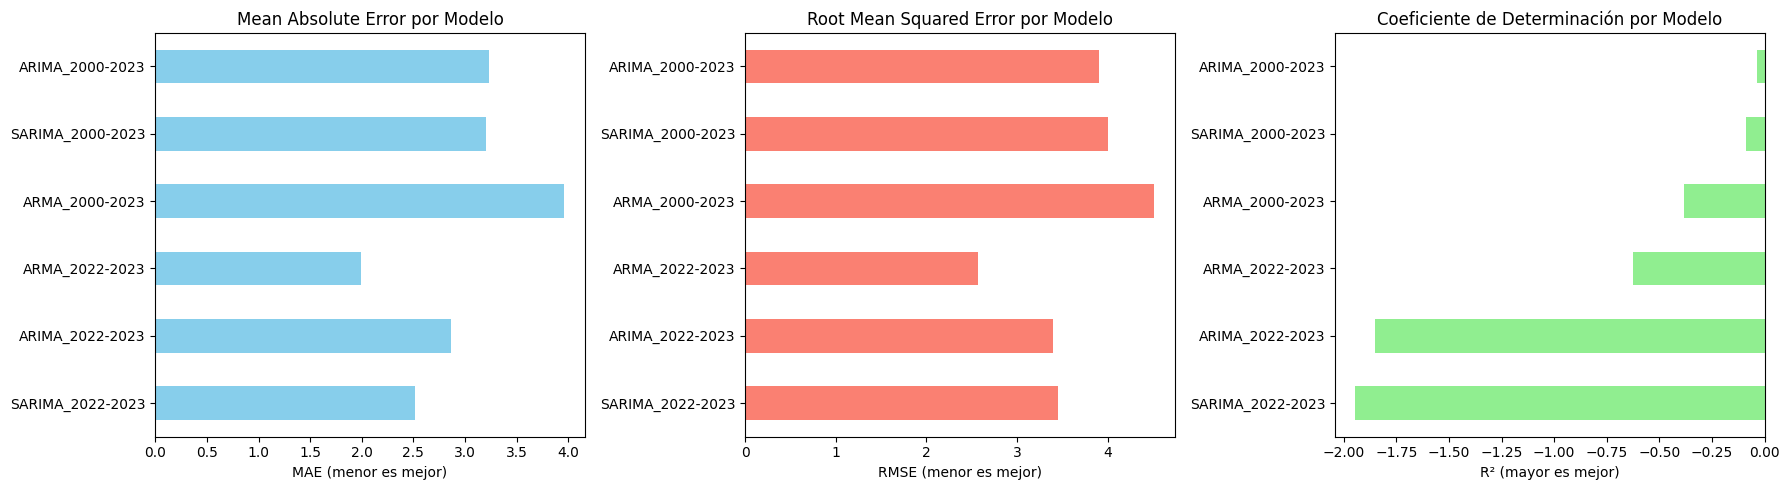

In [17]:
# Visualización de comparación de métricas
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Gráfico 1: MAE
df_comparacion_sorted.plot(kind='barh', y='MAE', ax=axes[0], color='skyblue', legend=False)
axes[0].set_xlabel('MAE (menor es mejor)')
axes[0].set_title('Mean Absolute Error por Modelo')
axes[0].invert_yaxis()

# Gráfico 2: RMSE
df_comparacion_sorted.plot(kind='barh', y='RMSE', ax=axes[1], color='salmon', legend=False)
axes[1].set_xlabel('RMSE (menor es mejor)')
axes[1].set_title('Root Mean Squared Error por Modelo')
axes[1].invert_yaxis()

# Gráfico 3: R²
df_comparacion_sorted.plot(kind='barh', y='R2', ax=axes[2], color='lightgreen', legend=False)
axes[2].set_xlabel('R² (mayor es mejor)')
axes[2].set_title('Coeficiente de Determinación por Modelo')
axes[2].invert_yaxis()

plt.tight_layout()
plt.show()

---

## Modelos con Variables Exógenas

Ahora entrenaremos los modelos ARMA, ARIMA y SARIMA con diferentes conjuntos de variables exógenas según los criterios especificados.

In [18]:
# Definir conjuntos de variables exógenas según los criterios
variables_sets = {
    'set1_ano_semana': ['ano', 'semana'],
    'set2_con_pandemia': ['ano', 'semana', 'pandemia_covid'],
    'set3_principales': ['ano', 'semana', 'ira_no_neumonia', 'neumonias_men5', 'neumonias_60mas',
                         'hospitalizados_60mas', 'defunciones_men5', 'defunciones_60mas'],
    'set4_con_lags': ['ano', 'semana', 'ira_no_neumonia', 'neumonias_men5', 'neumonias_60mas',
                      'hospitalizados_60mas', 'defunciones_men5', 'defunciones_60mas'],
    'set5_lags_selectos': ['ano', 'semana', 'hospitalizados_60mas_lag_1_semana',
                           'defunciones_men5_lag_1_semana', 'defunciones_60mas_lag_1_semana',
                           'defunciones_men5_lag_3_semana']
}

# Agregar variables lag al set4
lag_vars = []
for var in ['ira_no_neumonia', 'neumonias_men5', 'neumonias_60mas',
            'hospitalizados_60mas', 'defunciones_men5', 'defunciones_60mas']:
    for i in range(1, 7):
        lag_vars.append(f'{var}_lag_{i}_semana')

variables_sets['set4_con_lags'].extend(lag_vars)

print("Conjuntos de variables definidos:")
for key, vars_list in variables_sets.items():
    print(f"\n{key}: {len(vars_list)} variables")
    print(f"  {', '.join(vars_list[:5])}{'...' if len(vars_list) > 5 else ''}")

Conjuntos de variables definidos:

set1_ano_semana: 2 variables
  ano, semana

set2_con_pandemia: 3 variables
  ano, semana, pandemia_covid

set3_principales: 8 variables
  ano, semana, ira_no_neumonia, neumonias_men5, neumonias_60mas...

set4_con_lags: 44 variables
  ano, semana, ira_no_neumonia, neumonias_men5, neumonias_60mas...

set5_lags_selectos: 6 variables
  ano, semana, hospitalizados_60mas_lag_1_semana, defunciones_men5_lag_1_semana, defunciones_60mas_lag_1_semana...


### Periodo 2000-2023 con Variables Exógenas

In [19]:
# Entrenar modelos para periodo 2000-2023 con diferentes sets de variables
resultados_con_exogenas = {}

# Datos para 2000-2023
df_2000_2023_full = df.copy().sort_values(['ano', 'semana']).reset_index(drop=True)
y_2000_2023 = df_2000_2023_full['hospitalizados_men5']
split_idx = int(len(y_2000_2023) * 0.8)

# Iterar sobre los sets de variables
sets_2000_2023 = ['set1_ano_semana', 'set2_con_pandemia', 'set3_principales', 'set4_con_lags', 'set5_lags_selectos']

for set_name in sets_2000_2023:
    exog_vars = variables_sets[set_name]
    X_exog = df_2000_2023_full[exog_vars]
    
    X_train = X_exog[:split_idx]
    X_test = X_exog[split_idx:]
    y_train = y_2000_2023[:split_idx]
    y_test = y_2000_2023[split_idx:]
    
    # Nombre descriptivo de variables
    if set_name == 'set1_ano_semana':
        var_desc = 'ano, semana'
    elif set_name == 'set2_con_pandemia':
        var_desc = 'ano, semana, pandemia_covid'
    elif set_name == 'set3_principales':
        var_desc = 'principales'
    elif set_name == 'set4_con_lags':
        var_desc = 'principales + lags'
    else:  # set5_lags_selectos
        var_desc = 'lags selectos'
    
    # ARMA con variables exógenas (usando SARIMAX con d=0)
    try:
        model_arma = SARIMAX(y_train, exog=X_train, order=(2, 0, 2), 
                             enforce_stationarity=False, enforce_invertibility=False)
        fit_arma = model_arma.fit(disp=False)
        pred_arma = fit_arma.forecast(steps=len(y_test), exog=X_test)
        
        resultados_con_exogenas[f'ARMA_2000-2023_{set_name}'] = {
            'modelo': 'ARMA',
            'periodo': '2000-2023',
            'variables': var_desc,
            'MAE': mean_absolute_error(y_test, pred_arma),
            'RMSE': np.sqrt(mean_squared_error(y_test, pred_arma)),
            'R2': r2_score(y_test, pred_arma)
        }
    except Exception as e:
        print(f"Error en ARMA {set_name}: {e}")
    
    # ARIMA con variables exógenas
    try:
        model_arima = SARIMAX(y_train, exog=X_train, order=(2, 1, 2),
                              enforce_stationarity=False, enforce_invertibility=False)
        fit_arima = model_arima.fit(disp=False)
        pred_arima = fit_arima.forecast(steps=len(y_test), exog=X_test)
        
        resultados_con_exogenas[f'ARIMA_2000-2023_{set_name}'] = {
            'modelo': 'ARIMA',
            'periodo': '2000-2023',
            'variables': var_desc,
            'MAE': mean_absolute_error(y_test, pred_arima),
            'RMSE': np.sqrt(mean_squared_error(y_test, pred_arima)),
            'R2': r2_score(y_test, pred_arima)
        }
    except Exception as e:
        print(f"Error en ARIMA {set_name}: {e}")
    
    # SARIMA con variables exógenas
    try:
        model_sarima = SARIMAX(y_train, exog=X_train, order=(1, 1, 1),
                               seasonal_order=(1, 1, 1, 52),
                               enforce_stationarity=False, enforce_invertibility=False)
        fit_sarima = model_sarima.fit(disp=False)
        pred_sarima = fit_sarima.forecast(steps=len(y_test), exog=X_test)
        
        resultados_con_exogenas[f'SARIMA_2000-2023_{set_name}'] = {
            'modelo': 'SARIMA',
            'periodo': '2000-2023',
            'variables': var_desc,
            'MAE': mean_absolute_error(y_test, pred_sarima),
            'RMSE': np.sqrt(mean_squared_error(y_test, pred_sarima)),
            'R2': r2_score(y_test, pred_sarima)
        }
    except Exception as e:
        print(f"Error en SARIMA {set_name}: {e}")
    
    print(f"Completado: {set_name} para periodo 2000-2023")

print(f"\nTotal de modelos entrenados (2000-2023): {len(resultados_con_exogenas)}")

Completado: set1_ano_semana para periodo 2000-2023
Completado: set2_con_pandemia para periodo 2000-2023
Completado: set3_principales para periodo 2000-2023
Completado: set4_con_lags para periodo 2000-2023
Completado: set5_lags_selectos para periodo 2000-2023

Total de modelos entrenados (2000-2023): 15


### Periodo 2021-2023 con Variables Exógenas

In [20]:
# Entrenar modelos para periodo 2022-2023 con diferentes sets de variables
# Datos para 2022-2023
df_2022_2023_full = df[df['ano'] >= 2022].copy().sort_values(['ano', 'semana']).reset_index(drop=True)
y_2022_2023 = df_2022_2023_full['hospitalizados_men5']
split_idx_2022 = int(len(y_2022_2023) * 0.8)

# Iterar sobre los sets de variables (excluyendo set2_con_pandemia que es solo para 2000-2023)
sets_2022_2023 = ['set1_ano_semana', 'set3_principales', 'set4_con_lags', 'set5_lags_selectos']

for set_name in sets_2022_2023:
    exog_vars = variables_sets[set_name]
    X_exog = df_2022_2023_full[exog_vars]
    
    X_train = X_exog[:split_idx_2022]
    X_test = X_exog[split_idx_2022:]
    y_train = y_2022_2023[:split_idx_2022]
    y_test = y_2022_2023[split_idx_2022:]
    
    # Nombre descriptivo de variables
    if set_name == 'set1_ano_semana':
        var_desc = 'ano, semana'
    elif set_name == 'set3_principales':
        var_desc = 'principales'
    elif set_name == 'set4_con_lags':
        var_desc = 'principales + lags'
    else:  # set5_lags_selectos
        var_desc = 'lags selectos'
    
    # ARMA con variables exógenas
    try:
        model_arma = SARIMAX(y_train, exog=X_train, order=(2, 0, 2),
                             enforce_stationarity=False, enforce_invertibility=False)
        fit_arma = model_arma.fit(disp=False)
        pred_arma = fit_arma.forecast(steps=len(y_test), exog=X_test)
        
        resultados_con_exogenas[f'ARMA_2022-2023_{set_name}'] = {
            'modelo': 'ARMA',
            'periodo': '2022-2023',
            'variables': var_desc,
            'MAE': mean_absolute_error(y_test, pred_arma),
            'RMSE': np.sqrt(mean_squared_error(y_test, pred_arma)),
            'R2': r2_score(y_test, pred_arma)
        }
    except Exception as e:
        print(f"Error en ARMA {set_name}: {e}")
    
    # ARIMA con variables exógenas
    try:
        model_arima = SARIMAX(y_train, exog=X_train, order=(2, 1, 2),
                              enforce_stationarity=False, enforce_invertibility=False)
        fit_arima = model_arima.fit(disp=False)
        pred_arima = fit_arima.forecast(steps=len(y_test), exog=X_test)
        
        resultados_con_exogenas[f'ARIMA_2022-2023_{set_name}'] = {
            'modelo': 'ARIMA',
            'periodo': '2022-2023',
            'variables': var_desc,
            'MAE': mean_absolute_error(y_test, pred_arima),
            'RMSE': np.sqrt(mean_squared_error(y_test, pred_arima)),
            'R2': r2_score(y_test, pred_arima)
        }
    except Exception as e:
        print(f"Error en ARIMA {set_name}: {e}")
    
    # SARIMA con variables exógenas
    try:
        model_sarima = SARIMAX(y_train, exog=X_train, order=(1, 1, 1),
                               seasonal_order=(1, 1, 1, 52),
                               enforce_stationarity=False, enforce_invertibility=False)
        fit_sarima = model_sarima.fit(disp=False)
        pred_sarima = fit_sarima.forecast(steps=len(y_test), exog=X_test)
        
        resultados_con_exogenas[f'SARIMA_2022-2023_{set_name}'] = {
            'modelo': 'SARIMA',
            'periodo': '2022-2023',
            'variables': var_desc,
            'MAE': mean_absolute_error(y_test, pred_sarima),
            'RMSE': np.sqrt(mean_squared_error(y_test, pred_sarima)),
            'R2': r2_score(y_test, pred_sarima)
        }
    except Exception as e:
        print(f"Error en SARIMA {set_name}: {e}")
    
    print(f"Completado: {set_name} para periodo 2022-2023")

print(f"\nTotal de modelos entrenados (todos): {len(resultados_con_exogenas)}")

Completado: set1_ano_semana para periodo 2022-2023
Completado: set3_principales para periodo 2022-2023
Completado: set4_con_lags para periodo 2022-2023
Completado: set5_lags_selectos para periodo 2022-2023

Total de modelos entrenados (todos): 27


---

## Tabla Comparativa Completa - Formato Pivot Table

Tabla resumen con todas las combinaciones de modelos, periodos y variables.

In [21]:
# Crear DataFrame con todos los resultados
df_resultados_completo = pd.DataFrame(resultados_con_exogenas).T

# Resetear índice para tener una columna con el nombre completo del modelo
df_resultados_completo = df_resultados_completo.reset_index()
df_resultados_completo.rename(columns={'index': 'nombre_completo'}, inplace=True)

# Redondear métricas
df_resultados_completo[['MAE', 'RMSE', 'R2']] = df_resultados_completo[['MAE', 'RMSE', 'R2']].round(4)

# Reordenar columnas para la tabla pivote
df_pivot = df_resultados_completo[['periodo', 'modelo', 'variables', 'MAE', 'RMSE', 'R2']].copy()

# Ordenar por periodo, modelo y variables
df_pivot = df_pivot.sort_values(['periodo', 'modelo', 'variables']).reset_index(drop=True)

print("="*100)
print("TABLA COMPARATIVA COMPLETA - MODELOS DE SERIES TEMPORALES CON VARIABLES EXÓGENAS")
print("="*100)
print("\nTarget: hospitalizados_men5")
print("\nColumnas:")
print("  - Periodo: Rango de años utilizado para entrenamiento")
print("  - Modelo: Tipo de modelo (ARMA, ARIMA, SARIMA)")
print("  - Variables: Conjunto de variables exógenas utilizadas")
print("  - MAE: Mean Absolute Error (menor es mejor)")
print("  - RMSE: Root Mean Squared Error (menor es mejor)")
print("  - R²: Coeficiente de Determinación (mayor es mejor, cercano a 1)")
print("\n" + "="*100)
print(df_pivot.to_string(index=True))
print("\n" + "="*100)

TABLA COMPARATIVA COMPLETA - MODELOS DE SERIES TEMPORALES CON VARIABLES EXÓGENAS

Target: hospitalizados_men5

Columnas:
  - Periodo: Rango de años utilizado para entrenamiento
  - Modelo: Tipo de modelo (ARMA, ARIMA, SARIMA)
  - Variables: Conjunto de variables exógenas utilizadas
  - MAE: Mean Absolute Error (menor es mejor)
  - RMSE: Root Mean Squared Error (menor es mejor)
  - R²: Coeficiente de Determinación (mayor es mejor, cercano a 1)

      periodo  modelo                    variables            MAE           RMSE                  R2
0   2000-2023   ARIMA                  ano, semana       3.094146       3.820041            0.009789
1   2000-2023   ARIMA  ano, semana, pandemia_covid       2.761835       3.940013           -0.053385
2   2000-2023   ARIMA                lags selectos       3.446044       4.156261           -0.172188
3   2000-2023   ARIMA                  principales        3.41751       4.261163           -0.232105
4   2000-2023   ARIMA           principales + l

### Análisis de Mejores Modelos por Categoría

In [22]:
# Encontrar los mejores modelos por diferentes criterios
print("="*100)
print("ANÁLISIS DE MEJORES MODELOS")
print("="*100)

# Mejor modelo global por cada métrica
print("\n1. MEJOR MODELO GLOBAL (Todos los periodos y variables):")
print("-" * 100)
mejor_mae_global = df_pivot.loc[df_pivot['MAE'].idxmin()]
mejor_rmse_global = df_pivot.loc[df_pivot['RMSE'].idxmin()]
mejor_r2_global = df_pivot.loc[df_pivot['R2'].idxmax()]

print(f"\nMenor MAE: {mejor_mae_global['MAE']:.4f}")
print(f"  Periodo: {mejor_mae_global['periodo']}")
print(f"  Modelo: {mejor_mae_global['modelo']}")
print(f"  Variables: {mejor_mae_global['variables']}")

print(f"\nMenor RMSE: {mejor_rmse_global['RMSE']:.4f}")
print(f"  Periodo: {mejor_rmse_global['periodo']}")
print(f"  Modelo: {mejor_rmse_global['modelo']}")
print(f"  Variables: {mejor_rmse_global['variables']}")

print(f"\nMayor R²: {mejor_r2_global['R2']:.4f}")
print(f"  Periodo: {mejor_r2_global['periodo']}")
print(f"  Modelo: {mejor_r2_global['modelo']}")
print(f"  Variables: {mejor_r2_global['variables']}")

# Mejor modelo por periodo
print("\n" + "="*100)
print("2. MEJOR MODELO POR PERIODO:")
print("-" * 100)
for periodo in df_pivot['periodo'].unique():
    df_periodo = df_pivot[df_pivot['periodo'] == periodo]
    mejor_r2_periodo = df_periodo.loc[df_periodo['R2'].idxmax()]
    
    print(f"\n{periodo}:")
    print(f"  Modelo: {mejor_r2_periodo['modelo']}")
    print(f"  Variables: {mejor_r2_periodo['variables']}")
    print(f"  MAE: {mejor_r2_periodo['MAE']:.4f}")
    print(f"  RMSE: {mejor_r2_periodo['RMSE']:.4f}")
    print(f"  R²: {mejor_r2_periodo['R2']:.4f}")

# Mejor modelo por tipo (ARMA, ARIMA, SARIMA)
print("\n" + "="*100)
print("3. MEJOR MODELO POR TIPO:")
print("-" * 100)
for modelo_tipo in df_pivot['modelo'].unique():
    df_modelo = df_pivot[df_pivot['modelo'] == modelo_tipo]
    mejor_r2_modelo = df_modelo.loc[df_modelo['R2'].idxmax()]
    
    print(f"\n{modelo_tipo}:")
    print(f"  Periodo: {mejor_r2_modelo['periodo']}")
    print(f"  Variables: {mejor_r2_modelo['variables']}")
    print(f"  MAE: {mejor_r2_modelo['MAE']:.4f}")
    print(f"  RMSE: {mejor_r2_modelo['RMSE']:.4f}")
    print(f"  R²: {mejor_r2_modelo['R2']:.4f}")

# Comparación por conjunto de variables
print("\n" + "="*100)
print("4. DESEMPEÑO PROMEDIO POR CONJUNTO DE VARIABLES:")
print("-" * 100)
agg_vars = df_pivot.groupby('variables')[['MAE', 'RMSE', 'R2']].mean().round(4)
agg_vars = agg_vars.sort_values('R2', ascending=False)
print(agg_vars)

print("\n" + "="*100)

ANÁLISIS DE MEJORES MODELOS

1. MEJOR MODELO GLOBAL (Todos los periodos y variables):
----------------------------------------------------------------------------------------------------

Menor MAE: 1.7129
  Periodo: 2022-2023
  Modelo: ARMA
  Variables: lags selectos

Menor RMSE: 2.2671
  Periodo: 2022-2023
  Modelo: ARMA
  Variables: principales

Mayor R²: 0.0098
  Periodo: 2000-2023
  Modelo: ARIMA
  Variables: ano, semana

2. MEJOR MODELO POR PERIODO:
----------------------------------------------------------------------------------------------------

2000-2023:
  Modelo: ARIMA
  Variables: ano, semana
  MAE: 3.0941
  RMSE: 3.8200
  R²: 0.0098

2022-2023:
  Modelo: ARMA
  Variables: principales
  MAE: 1.9226
  RMSE: 2.2671
  R²: -0.2677

3. MEJOR MODELO POR TIPO:
----------------------------------------------------------------------------------------------------

ARIMA:
  Periodo: 2000-2023
  Variables: ano, semana
  MAE: 3.0941
  RMSE: 3.8200
  R²: 0.0098

ARMA:
  Periodo: 2000-20

### Visualización de Resultados - Heatmap Comparativo

### Exportar Resultados a CSV

In [23]:
# Guardar tabla de resultados en CSV
output_path = '../data/resultados_modelos_series_temporales.csv'
df_pivot.to_csv(output_path, index=False)
print(f"Tabla de resultados guardada en: {output_path}")

# Mostrar resumen final
print("\n" + "="*100)
print("RESUMEN FINAL")
print("="*100)
print(f"\nTotal de modelos entrenados: {len(df_pivot)}")
print(f"Periodos analizados: {df_pivot['periodo'].nunique()}")
print(f"Tipos de modelos: {', '.join(df_pivot['modelo'].unique())}")
print(f"Conjuntos de variables: {df_pivot['variables'].nunique()}")
print("\nArchivo de resultados generado exitosamente.")
print("="*100)

Tabla de resultados guardada en: ../data/resultados_modelos_series_temporales.csv

RESUMEN FINAL

Total de modelos entrenados: 27
Periodos analizados: 2
Tipos de modelos: ARIMA, ARMA, SARIMA
Conjuntos de variables: 5

Archivo de resultados generado exitosamente.
